<a href="https://colab.research.google.com/github/AEInha/Linear-Algebra/blob/main/formation_flight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formation flight

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE6029: Linear Optimal Control, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

You are operating a team of $K$ identical drones; one leader and $K-1$ follower drones, for which you are trying to design optimal formation flight trajectories.

Vehicle $k$'s dynamical behaviour in horizontal plane can be described by
$$
\begin{aligned}
  x^{(k)}_{t+1} &= Ax^{(k)}_t + Bu^{(k)}_t
\end{aligned}
$$
where the state vector $x^{(k)}_t \in \R^4$ consists of two positions ($p^{(k)}_t\in\R^2$) and two velocities ($v^{(k)}_t\in\R^2$). The vehicle's control $u^{(k)}_t\in\R^2$ is acceleration control for the two axes. Then the following matrices describe the above dynamics.
$$
A = \bmat{
1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t & 0 \\
0 & 1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t \\
0 & 0 & 1-\gamma\Delta t & 0 \\
0 & 0 & 0 & 1-\gamma\Delta t
} \\
B = \bmat{
0.5\Delta t^2 & 0 \\
0 & 0.5\Delta t^2 \\
\Delta t & 0 \\
0 & \Delta t
}
$$

We consider $t\in \{0,\dots,N-1\}$ with $N=1000$ and $\Delta t=0.02$, and we further assume that all the vehicles are (dynamically) identical, that is, they have the same $A$ and $B$.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ssp
import scipy.sparse.linalg as sla

n = 1000 # number of timesteps
T = 20 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,n+1)
delt = T/n
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

<br>

We assume that the vehicles are initially at random position with random velocity. You can assume that the random variables are normally distributed.

In [2]:
K = 50      # 50 drones

np.random.seed(1)

p_0 = np.random.randn(2,K)*5    # initial positions
v_0 = np.random.randn(2,K)      # initial velocities

<br>

The initial position and the velocity is visualized below:

Initial position:
 [[  8.12172682  -3.05878207  -2.64085876  -5.36484311   4.32703815
  -11.50769348   8.72405882  -3.8060345    1.59519548  -1.24685188
    7.31053969 -10.30070355  -1.61208602  -1.92027177   5.66884721
   -5.49945634  -0.86214104  -4.38929209   0.21106873   2.91407607
   -5.50309589   5.72361855   4.5079536    2.51247169   4.50427975
   -3.4186393   -0.61445113  -4.67884717  -1.3394404    2.65177733
   -3.45830376  -1.98376763  -3.4358635   -4.22602821  -3.35623065
   -0.06332299  -5.58655174   1.17207849   8.29901089   3.7102208
   -0.95917776  -4.43814482  -3.73579147   8.46227301   0.25403877
   -3.18497823   0.95457742  10.50127568   0.60079476   3.08601555]
 [  1.5008516   -1.76124923  -5.71259099  -1.74671361  -1.04447117
    2.93311596   4.19491707   4.65551041   1.42793663   4.42570582
   -3.7719897    6.26434078   2.5646491   -1.49046418   2.44259073
   -0.37785857   5.65814694   7.59908408  10.92787703  -6.98248168
   -7.22056903  -2.52232931   0.80018535   

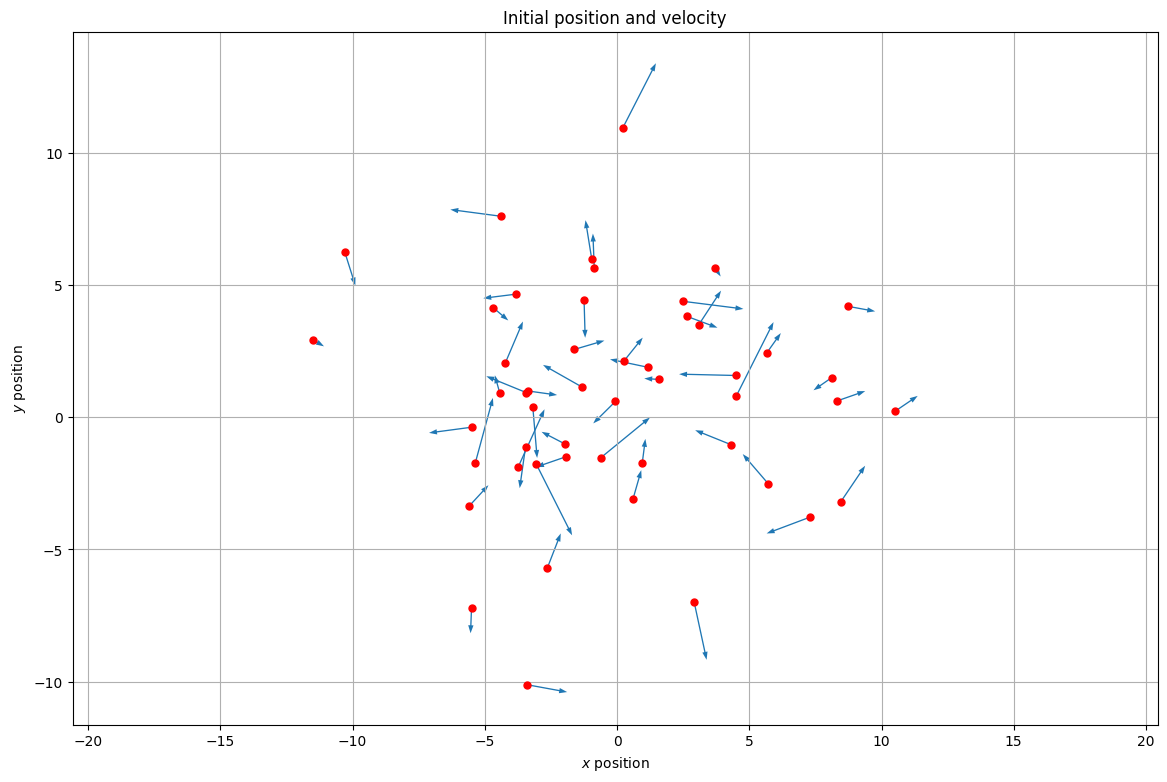

In [3]:
print("Initial position:\n", p_0)
print("Initial velocity:\n", v_0)

plt.figure(figsize=(14,9), dpi=100)
for i in range(K):
  plt.plot(p_0[0,i], p_0[1,i], 'ro', markersize=5)
  plt.arrow(p_0[0,i], p_0[1,i], v_0[0,i], v_0[1,i], head_width=0.2, width=0.05, ec='none')
plt.title('Initial position and velocity')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

<br>

You are required to find the minimum energy formation trajectory that achieves the following formation at $t=N$.

- The position of the followers are defined relative to the leader. For example, equispaced circular formation around the leader can be speficied as follows.
$$
  p^{(k)}_N = p^{(1)}_N + r_\text{formation}\bmat{\sin\frac{2\pi (k-1)}{(K-1)} \\ \cos\frac{2\pi (k-1)}{(K-1)} }
$$
- The velocity of the followers (vehicle $2,\dots,K$) should be equal to the leader's velocity ($v^{(k)}_N = v^{(1)}_N$ for $k=2,\dots,K$).
- The leader (vehicle $1$) has the predefined final velocity ($v^{(1)}_N = v_f\in\R^2$).


Note that **the leader's final position, $p^{(1)}_N$ is unconstrained.**

<br>

Find the optimal formation flight trajectories by solving the following problem, **via the least norm solution approach**.
$$
\begin{aligned}
  \underset{u_t^{(k)}}{\minimize} \quad & \sum_{k=1}^K\sum_{t=0}^{N-1} \|u^{(k)}_t\|^2 \\
  \text{subject to}  \quad  &x^{(k)}_{t+1} = Ax^{(k)}_t + Bu^{(k)}_t, \quad\text{for }t=0,\dots,N-1 \text{ and }k=1,\dots,K,\\
  &v^{(k)}_N = v^{(1)}_N, \quad\text{for }k=2,\dots,K, \\
  &p^{(k)}_N = p^{(1)}_N + r_\text{formation}\bmat{\sin\frac{2\pi (k-1)}{(K-1)} \\ \cos\frac{2\pi (k-1)}{(K-1)} }, \quad\text{for }k=2,\dots,K.
\end{aligned}
$$

In [4]:
v_f = [5, 0]       # desired final velocity of the leader
r_formation = 5    # the radius of the formation circle

<br>

_Hint: Define your state variable as the $4K$-vector containing the states of all drones,
$$
  x_t = \bmat{x_t^{(1)} \\ \vdots \\ x_t^{(K)}}
$$
and the control variable as the $2K$-vector containing the controls of all drones:
$$
  u_t = \bmat{u_t^{(1)} \\ \vdots \\ u_t^{(K)}}
$$
Expressing the linear dynamics and the optimization problem in terms of these will help._


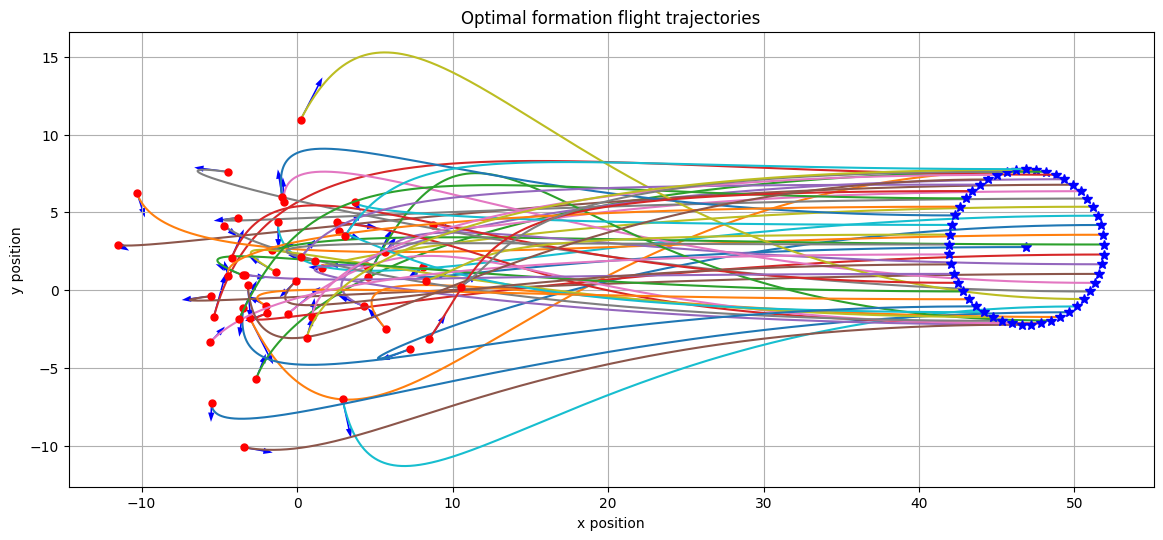

In [8]:
##A_c를 계산

A_total = np.zeros([len(A)*K,len(A)*K])
for i in range(K):
  A_total[4*i:4*(i+1),4*i:4*(i+1)] = A

##B_c를 계산

B_total = np.zeros([len(B)*K,len(B[0])*K])
for i in range(K):
  B_total[4*i:4*(i+1),2*i:2*(i+1)] = B

##A_c1000를 계산
A_total_1000 = np.linalg.matrix_power(A_total,n)


##B_c1000를 계산
B_total_1000 = np.zeros([4*K,2*K*n])

for i in range(n):
  B_total_1000[:,2*K*i:2*K*(i+1)] = np.linalg.matrix_power(A_total,n-i)@B_total


##C 계산
C = np.zeros([len(A)*K,len(A)])
for i in range(K):
  C[len(A)*i:len(A)*(i+1),:] = np.eye(len(A))
##C1과 C2 쪼개기
C1 = C[:,0:2]
C2 = C[:,2:]

##D 계산
D = np.zeros(len(A)*K)
for i in range(1,K):
  D[len(A)*i] = r_formation  * np.sin(2*np.pi*(i) /(K-1))
  D[len(A)*i+1] = r_formation  * np.cos(2*np.pi*(i) /(K-1))

x0 = np.zeros(K*len(A))
for i in range(K):
  x0[len(A)*i:len(A)*i+int(len(A)/2)] = p_0[:,i]
  x0[len(A)*i+2:len(A)*(i+1)] = v_0[:,i]


A_new = np.linalg.pinv(B_total_1000)@C1

B_new = np.linalg.pinv(B_total_1000)@(C2@v_f + D - A_total_1000@x0)


p_fin = np.linalg.pinv(A_new)@(-B_new)

X_1000 = C1 @ p_fin + C2 @ v_f + D

U   = np.linalg.lstsq(B_total_1000,X_1000 - np.linalg.matrix_power(A_total,n)@x0, rcond=0)[0]

plt.figure(figsize=(14, 9),dpi = 100)
for k in range(K):
  x_drone0 = np.hstack([p_0[:,k],v_0[:,k]])
  drone_x = np.zeros(n)
  drone_y = np.zeros(n)
  drone_v_x = np.zeros(n)
  drone_v_y = np.zeros(n)
  for i in range(n):
    u=U[100*i+2*k:100*i+2*(k+1)]
    x_drone0 = A@x_drone0 + B@u
    drone_x[i] = x_drone0[0]
    drone_y[i] = x_drone0[1]
    drone_v_x[i] = x_drone0[2]
    drone_v_y[i] = x_drone0[3]
  plt.plot(drone_x,drone_y)
  plt.plot(drone_x[0], drone_y[0], 'o', markersize=5, color = "red")
  plt.arrow(drone_x[0], drone_y[0], drone_v_x[0], drone_v_y[0], head_width=0.4, width=0.1, color = "blue", ec='none')
  plt.plot(drone_x[-1], drone_y[-1], '*', markersize=7, label='Target position',color = "blue")
plt.title("Optimal formation flight trajectories")
plt.xlabel("x position")
plt.ylabel("y position")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')


Your results should look something like the above picture.